In [1]:
import pandas as pd
import json
import os
from collections import defaultdict, Counter
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import hypergeom, wilcoxon,fisher_exact
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data
uniprot_df = pd.read_csv('../data/uniprotkb_AND_model_organism_9606_2024_08_12.tsv', sep='\t')
NCBI_df = pd.read_csv('../data/ncbi_dataset.tsv', sep='\t')
Symbol_uniport_dict = NCBI_df.set_index('Symbol')['SwissProt Accessions'].to_dict()
Symbol_uniport_series = pd.Series(Symbol_uniport_dict)
Symbol_uniport_series = Symbol_uniport_series.fillna('')
Symbol_uniport_dict = Symbol_uniport_series.to_dict()
string_entry_dict = uniprot_df[~uniprot_df['STRING'].isna()].set_index('STRING')['Entry'].to_dict()
string_entry_dict = {k.split(';')[0]:v for k,v in string_entry_dict.items()}
entry_string_dict ={v:k for k, v in string_entry_dict.items()}
Symbol_string_dict = {k:entry_string_dict[v] for k,v in Symbol_uniport_dict.items() if v in entry_string_dict}
string_Symbol_dict = {v:k for k,v in Symbol_string_dict.items()}

with open('../data/hmdb_id.json') as f:
    hmdb_dict = json.load(f)
hmdb_name_dict = {}
for hmid, ann_dict in hmdb_dict.items():
    hmdb_name_dict[hmid] = ann_dict['name']
kegg_hmdb_dict = {}
for hmdb_id, ann_dict in hmdb_dict.items():
    if ('kegg_id' in ann_dict) and (ann_dict['kegg_id'] != ''):
        kegg_hmdb_dict[ann_dict['kegg_id']] = hmdb_id
uniprot_symbol_dict = {v:k for k,v in Symbol_uniport_dict.items()}
hmdb_reverse_dict = {v:k for k,v in hmdb_name_dict.items()}

entry_kegg_dict = uniprot_df[~uniprot_df['KEGG'].isna()].set_index('Entry').to_dict()['KEGG']
entry_kegg_dict ={k:v.split(';')[:-1] for k,v in entry_kegg_dict.items()}
string_kegg_dict = {k:entry_kegg_dict[v] for k,v in string_entry_dict.items() if v in entry_kegg_dict}
hmdb_kegg_dict =  {}
for k_id, hm_id in kegg_hmdb_dict.items():
    if hm_id not in hmdb_kegg_dict:
        hmdb_kegg_dict[hm_id] = []
    hmdb_kegg_dict[hm_id].append(k_id)
kegg_info_dict = {}
with open('../data/pathway_information.txt') as f:
    for line in f:
        line = line.strip()
        kegg_info_dict[line.split('\t')[0]] = line.split('\t')[1]
kegg_p_dict = {}
with open('../data/pathway_gene_mapping.txt') as f:
    for line in f:
        line = line.strip()
        pathway = line.split('\t')[0][5:]
        gene = line.split('\t')[1]
        if pathway not in kegg_p_dict:
            kegg_p_dict[pathway] = []
        kegg_p_dict[pathway].append(gene)
kegg_m_dict = {}
with open('../data/pathway_meta_mapping.txt') as f:
    for line in f:
        line = line.strip()
        pathway = 'hsa' + line.split('\t')[1][8:]
        meta = line.split('\t')[0][4:]
        if pathway not in kegg_m_dict:
            kegg_m_dict[pathway] = []
        kegg_m_dict[pathway].append(meta)
kegg_info_dict = {k:v.split(' - Homo sapiens (human)')[0] for k,v in kegg_info_dict.items()}

In [3]:
blood_meta_mapping_dict = {}
with open('../data/validation_tissue/blood_meta_mapping.txt') as f:
    for line in f:
        line = line.strip('\n')
        blood_meta_mapping_dict[line.split('\t')[0]] = line.split('\t')[1]
blood_PMI_raw_df = pd.read_csv('../data/validation_tissue/plasma_blood.csv')
blood_PMI_raw_ex_df = blood_PMI_raw_df[blood_PMI_raw_df['META_Q'] < 0.05]
blood_PMI_raw_ex_df['Target_Gene'] = blood_PMI_raw_ex_df['Target_Gene'].str.split(' ')
blood_PMI_raw_ex_df = blood_PMI_raw_ex_df.explode('Target_Gene').reset_index(drop=True)
blood_PMI_raw_ex_df = blood_PMI_raw_ex_df[(blood_PMI_raw_ex_df['Target_Gene'].isin(Symbol_string_dict))&(blood_PMI_raw_ex_df['Metabolite_Name'].isin(blood_meta_mapping_dict))]
blood_PMI_raw_ex_df['string'] = blood_PMI_raw_ex_df['Target_Gene'].apply(lambda x:Symbol_string_dict[x])
blood_PMI_raw_ex_df['hmdb'] = blood_PMI_raw_ex_df['Metabolite_Name'].apply(lambda x:blood_meta_mapping_dict[x])
blood_PMI_raw_ex_df = blood_PMI_raw_ex_df[(blood_PMI_raw_ex_df['string'] != '')&(blood_PMI_raw_ex_df['hmdb'] != '')].drop_duplicates(subset=['string','hmdb'])
blood_pro_mapping_dict = blood_PMI_raw_ex_df.set_index('Target_Name').to_dict()['string']
meta_type_df = pd.read_csv('../data/validation_tissue/metatype.csv')
meta_type_df = meta_type_df[meta_type_df['m.hmdb_id'] != '']
meta_type_dict = meta_type_df.set_index('m.hmdb_id').to_dict()['m.refmet_SuperClass']
lipids = ['Fatty Acyls', 'Glycerophospholipids', 'Sphingolipids', 'Glycerolipids', 'Sterol Lipids', 'Prenol Lipids']
meta_type_dict = {k:'Lipids' if v in lipids else v for k,v in meta_type_dict.items()}

In [4]:
blood_original_df = pd.read_csv('../results/tissue_type/blood_edges.csv', sep=',')
blood_prediction_df = pd.read_csv('../results/tissue_type/blood_prediction.csv', sep=',')

m_node = blood_original_df[blood_original_df['edge_type'] == 'PMI']['node1'].unique().tolist()
p_node = blood_original_df[blood_original_df['edge_type'] == 'PMI']['node2'].unique().tolist()
blood_mapping_df = blood_PMI_raw_ex_df[(blood_PMI_raw_ex_df['hmdb'].isin(m_node))&(blood_PMI_raw_ex_df['string'].isin(p_node))]
print(len(m_node), len(p_node))
print(len(blood_mapping_df))
print(len(blood_mapping_df['string'].unique()), len(blood_mapping_df['hmdb'].unique()))

matched_blood_ori_df = pd.merge(blood_original_df, blood_PMI_raw_ex_df, left_on=['node1', 'node2'], right_on=['hmdb', 'string'])
matched_blood_ori_df = matched_blood_ori_df.drop(columns=['hmdb', 'string'])
print(len(matched_blood_ori_df))

matched_blood_pred_df = pd.merge(blood_prediction_df, blood_PMI_raw_ex_df, left_on=['metabolite', 'protein'], right_on=['hmdb', 'string'])
matched_blood_pred_df = matched_blood_pred_df.drop(columns=['hmdb', 'string'])
print(len(matched_blood_pred_df))
print(len(matched_blood_pred_df[matched_blood_pred_df['pred_score'] >= 0.9]))
print(len(matched_blood_pred_df[matched_blood_pred_df['pred_score'] >= 0.95]))
print(len(matched_blood_pred_df[matched_blood_pred_df['pred_score'] >= 0.99]))

1467 2127
8246
252 75
304
7740
6976
5971
2125


In [5]:
blood_top15000_df = blood_prediction_df.sort_values(by='pred_score', ascending=False).head(15000)
blood_top10000_df = blood_prediction_df.sort_values(by='pred_score', ascending=False).head(10000)
blood_top5000_df = blood_prediction_df.sort_values(by='pred_score', ascending=False).head(5000)
matched_blood_top15000_df = pd.merge(blood_top15000_df, blood_PMI_raw_ex_df, left_on=['metabolite', 'protein'], right_on=['hmdb', 'string'])
matched_blood_top15000_df = matched_blood_top15000_df.drop(columns=['hmdb', 'string'])
print(len(matched_blood_top15000_df))

211


In [6]:
def compute_empirical_pvalues(candidate_df, matched_df):
    candidate_scores = candidate_df['pred_score'].values
    N = len(candidate_scores)
    
    pvals = []
    for s in matched_df['pred_score']:
        p = np.sum(candidate_scores >= s) / N
        pvals.append(p)

    matched_df = matched_df.copy()
    matched_df['p_value_empirical'] = pvals
    return matched_df
    
def compute_permutation_pvalues(candidate_df, matched_df, n_perm=10000):
    candidate_scores = candidate_df['pred_score'].values

    pvals = []
    for s in matched_df['pred_score']:
        perm_samples = np.random.choice(candidate_scores, size=n_perm, replace=True)
        p = np.mean(perm_samples >= s)
        pvals.append(p)
    
    matched_df = matched_df.copy()
    matched_df['p_value_permutation'] = pvals
    return matched_df

In [7]:
match_blood_df = compute_empirical_pvalues(blood_prediction_df, matched_blood_pred_df)
match_blood_p_df = compute_permutation_pvalues(blood_prediction_df, match_blood_df)
print(len(match_blood_p_df[(match_blood_p_df['p_value_empirical'] < 0.05)&(match_blood_p_df['p_value_permutation'] < 0.05)]))

1461


In [ ]:
'''
def build_network(original_edge_df, prediction_edge_df, top_n=None):
    """
    Build a network by adding original edges and, if specified, the top_n predicted edges.
    
    Parameters:
        original_edge_df: DataFrame with original edges (columns: 'node1', 'node2').
        prediction_edge_df: DataFrame with predicted edges 
                            (columns: 'metabolite', 'protein', 'pred_score').
        top_n: int or None. If int, add top_n predicted edges (sorted by pred_score in descending order).
        
    Returns:
        G: networkx.Graph with combined edges.
    """
    G = nx.Graph()
    for _, row in original_edge_df.iterrows():
        G.add_edge(row['node1'], row['node2'], source='original')
    
    if top_n is not None:
        pred_top = prediction_edge_df.sort_values(by='pred_score', ascending=False).head(top_n)
        for _, row in pred_top.iterrows():
            G.add_edge(row['metabolite'], row['protein'], source='prediction', pred_score=row['pred_score'])   
    return G

def visualize_original_network(G, original_edge_df):
    """
    Visualize the original network G by differentiating between metabolite and protein nodes.
    
    Parameters:
        G: networkx.Graph representing the original network.
        original_edge_df: DataFrame containing original edges with columns 'node1' (metabolite) and 'node2' (protein).
    """
    # Identify metabolite and protein nodes based on the original edge DataFrame
    metabolite_nodes = set(original_edge_df['node1'])
    protein_nodes = set(original_edge_df['node2'])
    
    # Compute node positions using spring layout
    pos = nx.spring_layout(G, seed=42,k=0.2)
    
    plt.figure(figsize=(10, 10))
    # Draw metabolite nodes (red)
    nx.draw_networkx_nodes(G, pos, nodelist=list(metabolite_nodes), 
                           node_color='red', label='Metabolites', node_size=10)
    # Draw protein nodes (blue)
    nx.draw_networkx_nodes(G, pos, nodelist=list(protein_nodes), 
                           node_color='blue', label='Proteins', node_size=10)
    
    # Draw edges with some transparency
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    plt.title("Original Network Visualization")
    plt.legend()
    plt.axis("off")
    plt.show()

def analyze_network_topology(G):
    """
    Compute basic network topology metrics, including:
      - Number of nodes and edges
      - Average degree and density
      - Average clustering coefficient
      - Diameter (computed on the largest connected component if graph is disconnected)
      - Modularity (using greedy modularity communities)
      
    Parameters:
        G: networkx.Graph
        
    Returns:
        sta
    """
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    degrees = [d for _, d in G.degree()]
    avg_degree = sum(degrees) / num_nodes if num_nodes > 0 else 0
    density = nx.density(G)
    clustering = nx.average_clustering(G)
    
    if nx.is_connected(G):
        diameter = nx.diameter(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        diameter = nx.diameter(G.subgraph(largest_cc))
    
    # Compute communities and modularity
    communities = list(nx.algorithms.community.greedy_modularity_communities(G))
    modularity = nx.algorithms.community.modularity(G, communities)
    
    stats = {
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'avg_degree': avg_degree,
        'density': density,
        'avg_clustering': clustering,
        'diameter': diameter,
        'modularity': modularity
    }
    return stats

def compute_integrated_ranking(G):
    """
    Compute integrated hub ranking for all nodes in G by combining degree, betweenness, 
    and closeness centrality rankings. For each node, first compute its rank in each 
    centrality measure (with rank 1 as the highest), then calculate the average rank. 
    The nodes are then re-ranked by this average (lower average indicates higher importance).
    
    Parameters:
        G: networkx.Graph
        
    Returns:
        df: DataFrame with columns ['node', 'integrated_rank'].
    """
    deg_cent = nx.degree_centrality(G)
    bet_cent = nx.betweenness_centrality(G)
    clo_cent = nx.closeness_centrality(G)
    
    df = pd.DataFrame({'node': list(G.nodes())})
    df['degree'] = df['node'].map(deg_cent)
    df['betweenness'] = df['node'].map(bet_cent)
    df['closeness'] = df['node'].map(clo_cent)
    
    # Ranking: higher centrality gets lower rank number (i.e., rank 1 = highest centrality)
    df['rank_degree'] = df['degree'].rank(method='min', ascending=False)
    df['rank_betweenness'] = df['betweenness'].rank(method='min', ascending=False)
    df['rank_closeness'] = df['closeness'].rank(method='min', ascending=False)
    
    # Compute average rank
    df['average_rank'] = df[['rank_degree', 'rank_betweenness', 'rank_closeness']].mean(axis=1)
    df = df.sort_values(by='average_rank')
    df['integrated_rank'] = range(1, len(df) + 1)
    
    return df[['node', 'integrated_rank']]

def compile_integrated_rankings(networks_dict):
    """
    Compute and merge the integrated hub rankings for multiple networks.
    
    Parameters:
        networks_dict: dict where keys are network labels (e.g., 'Original', 'Pred_top_5000', etc.)
                       and values are corresponding networkx.Graph objects.
                       
    Returns:
        ranking_df: DataFrame with columns for node id and integrated ranking for each network.
    """
    ranking_df = None
    for label, G in networks_dict.items():
        df = compute_integrated_ranking(G)
        df = df.rename(columns={'integrated_rank': label})
        if ranking_df is None:
            ranking_df = df
        else:
            ranking_df = pd.merge(ranking_df, df, on='node', how='outer')
    return ranking_df

def compile_network_statistics(networks_dict):
    """
    Compute network topology metrics for each network and compile into a DataFrame.
    
    Parameters:
        networks_dict: dict where keys are network labels and values are networkx.Graph objects.
        
    Returns:
        df_stats: DataFrame with one row per network and columns for each metric.
    """
    rows = []
    for label, G in networks_dict.items():
        stats = analyze_network_topology(G)
        row = {'Network': label}
        row.update(stats)
        rows.append(row)
    df_stats = pd.DataFrame(rows)
    return df_stats

def analyze_edge_connection_patterns(original_edge_df, action_ex_df, G):
    """
    Analyze the connection patterns of known PMI edge types. For each edge type,
    compute:
      - The average difference in degree centrality between the two connected nodes.
      - The ratio of edges connecting nodes in the same community.
      
    Parameters:
        original_edge_df: DataFrame with original edges (columns: 'node1', 'node2').
        action_ex_df: DataFrame with PMI edge type information (columns: '代谢物', 'protein', 'mode').
        G: networkx.Graph corresponding to the original network.
        
    Returns:
        stats_by_mode: DataFrame with statistics for each edge type.
    """
    # Merge to get mode information for edges present in the original network
    merged_df = pd.merge(original_edge_df, action_ex_df, left_on=['node1', 'node2'], 
                         right_on=['metabolite', 'protein'], how='inner')
    
    deg_cent = nx.degree_centrality(G)
    communities = list(nx.algorithms.community.greedy_modularity_communities(G))
    
    # Map each node to its community index
    node_to_comm = {}
    for i, comm in enumerate(communities):
        for node in comm:
            node_to_comm[node] = i
    
    deg_diff_list = []
    same_comm_list = []
    
    for _, row in merged_df.iterrows():
        n1 = row['node1']
        n2 = row['node2']
        diff = abs(deg_cent.get(n1, 0) - deg_cent.get(n2, 0))
        same_comm = 1 if (n1 in node_to_comm and n2 in node_to_comm and node_to_comm[n1] == node_to_comm[n2]) else 0
        deg_diff_list.append(diff)
        same_comm_list.append(same_comm)
    
    merged_df['degree_diff'] = deg_diff_list
    merged_df['same_community'] = same_comm_list
    
    stats_by_mode = merged_df.groupby('mode').agg(
        avg_degree_diff=('degree_diff', 'mean'),
        same_comm_ratio=('same_community', 'mean'),
        edge_count=('mode', 'count')
    ).reset_index()
    
    return stats_by_mode

def compute_edge_hub_ranking(G, method='node', network_label="Original"):
    """
    Compute the hub score for each edge in the network G and assign a ranking.
    
    For the 'node' method:
      - The hub score for an edge is defined as the average integrated hub ranking of its endpoints.
      - Lower hub scores indicate a more hub-like edge.
    
    For the 'betweenness' method:
      - The hub score is the edge betweenness centrality.
      - Higher betweenness values indicate a more hub-like edge.
    
    The function ensures that each edge is represented with the metabolite node in the first column and the protein node in the second.
    
    Parameters:
        G: networkx.Graph - the network.
        method: str - either 'node' or 'betweenness'.
        network_label: str - the column name to assign for this network's ranking.
        
    Returns:
        df: DataFrame with columns ['Metabolite', 'Protein', network_label] where the ranking is assigned.
    """
    records = []
    
    # For node-based method, first compute integrated hub ranking for nodes.
    if method == 'node':
        node_rank_df = compute_integrated_ranking(G)  # previously defined function
        node_rank_dict = dict(zip(node_rank_df['node'], node_rank_df['integrated_rank']))
    elif method == 'betweenness':
        edge_btw = nx.edge_betweenness_centrality(G)
    
    for edge in G.edges():
        u, v = edge
        # Determine which node is metabolite and which is protein based on ID prefix.
        if str(u).startswith("HMDB"):
            metabolite = u
            protein = v
        elif str(v).startswith("HMDB"):
            metabolite = v
            protein = u
        else:
            # Fallback: if none starts with HMDB, check if u starts with "9606"
            if str(u).startswith("9606"):
                protein = u
                metabolite = v
            else:
                protein = v
                metabolite = u
        
        # Compute hub score for the edge
        if method == 'node':
            rank_u = node_rank_dict.get(u, None)
            rank_v = node_rank_dict.get(v, None)
            if rank_u is not None and rank_v is not None:
                hub_score = (rank_u + rank_v) / 2.0
            else:
                hub_score = None
        elif method == 'betweenness':
            hub_score = edge_btw.get(edge, None)
            if hub_score is None:
                hub_score = edge_btw.get((v, u), None)
        
        records.append({'Metabolite': metabolite, 'Protein': protein, 'hub_score': hub_score})
    
    df = pd.DataFrame(records)
    # Remove edges with missing hub_score (if any)
    df = df.dropna(subset=['hub_score'])
    
    # Rank the edges:
    # - For the node-based method, lower hub_score means a more hub-like edge.
    # - For the betweenness method, higher hub_score means a more hub-like edge.
    if method == 'node':
        df = df.sort_values(by='hub_score', ascending=True).reset_index(drop=True)
    elif method == 'betweenness':
        df = df.sort_values(by='hub_score', ascending=False).reset_index(drop=True)
    
    # Assign ranking (starting from 1)
    df[network_label] = range(1, len(df) + 1)
    # Keep only the required columns
    df = df[['Metabolite', 'Protein', network_label]]
    return df

def merge_edge_hub_rankings(networks_dict, hmdb_name_dict, string_Symbol_dict, method='node'):
    """
    For each network in networks_dict, compute the edge hub ranking using the specified method,
    and merge the results into a single DataFrame.
    
    Parameters:
        networks_dict: dict - keys are network labels (e.g., 'Original', 'Pred_top_5000', etc.)
                              and values are networkx.Graph objects.
        method: str - either 'node' or 'betweenness'.
        
    Returns:
        merged_df: DataFrame with columns ['Metabolite', 'Protein', 'Original', 'Pred_top_5000', ...].
                   For an edge not present in a particular network, the corresponding cell is empty.
    """
    merged_df = None
    for label, G in networks_dict.items():
        df_edge = compute_edge_hub_ranking(G, method=method, network_label=label)
        if merged_df is None:
            merged_df = df_edge
        else:
            merged_df = pd.merge(merged_df, df_edge, on=['Metabolite', 'Protein'], how='outer')
    merged_df['meta_id'] = merged_df['Metabolite'].apply(lambda x:hmdb_name_dict[x])
    merged_df['pro_id'] = merged_df['Protein'].apply(lambda x:string_Symbol_dict[x])
    return merged_df

def flatten_kegg_ids(kegg_series):
    """
    Flatten a pandas Series of kegg_id values.
    If an element is a list, each item is added separately.
    """
    flat_set = set()
    for item in kegg_series:
        if isinstance(item, list):
            for sub in item:
                flat_set.add(sub)
        else:
            flat_set.add(item)
    return flat_set

def annotate_network_nodes(G, string_kegg_dict, hmdb_kegg_dict):
    """
    Annotate nodes in network G with KEGG IDs.
    
    Parameters:
      G: networkx.Graph representing the network.
      string_kegg_dict: dict mapping protein node IDs to KEGG IDs.
      hmdb_kegg_dict: dict mapping metabolite node IDs to KEGG IDs.
      
    Returns:
      DataFrame with columns ['node', 'type', 'kegg_id'].
    """
    data = []
    for node in G.nodes():
        if node in string_kegg_dict:
            data.append({'node': node, 'type': 'protein', 'kegg_id': string_kegg_dict[node]})
        elif node in hmdb_kegg_dict:
            data.append({'node': node, 'type': 'metabolite', 'kegg_id': hmdb_kegg_dict[node]})
        else:
            data.append({'node': node, 'type': 'unknown', 'kegg_id': None})
    return pd.DataFrame(data)

def compute_coverage_for_network(G, string_kegg_dict, hmdb_kegg_dict, kegg_p_dict, kegg_m_dict):
    """
    For a given network G, compute pathway coverage metrics:
      For each KEGG pathway:
         - Protein_Count: Number of network proteins present in the pathway.
         - Protein_Total: Total number of proteins annotated in the pathway (from kegg_p_dict).
         - Protein_Completeness = Protein_Count / Protein_Total.
         - Similarly for metabolites.
    Returns a DataFrame keyed on 'Pathway' with these metrics.
    """
    ann_df = annotate_network_nodes(G, string_kegg_dict, hmdb_kegg_dict)
    protein_series = ann_df.loc[ann_df['type'] == 'protein', 'kegg_id'].dropna()
    network_proteins = flatten_kegg_ids(protein_series)
    metabolite_series = ann_df.loc[ann_df['type'] == 'metabolite', 'kegg_id'].dropna()
    network_metabolites = flatten_kegg_ids(metabolite_series)
    
    # Define the union of pathways (keys in protein and metabolite dictionaries)
    pathways = set(kegg_p_dict.keys()) | set(kegg_m_dict.keys())
    records = []
    for pathway in pathways:
        prot_in_path = set(kegg_p_dict.get(pathway, []))
        metab_in_path = set(kegg_m_dict.get(pathway, []))
        protein_total = len(prot_in_path)
        metabolite_total = len(metab_in_path)
        protein_count = len(network_proteins & prot_in_path)
        metabolite_count = len(network_metabolites & metab_in_path)
        protein_completeness = protein_count / protein_total if protein_total > 0 else None
        metabolite_completeness = metabolite_count / metabolite_total if metabolite_total > 0 else None
        record = {
            'Pathway': pathway,
            'Protein_Count': protein_count,
            'Protein_Total': protein_total,
            'Protein_Completeness': protein_completeness,
            'Metabolite_Count': metabolite_count,
            'Metabolite_Total': metabolite_total,
            'Metabolite_Completeness': metabolite_completeness
        }
        records.append(record)
    df = pd.DataFrame(records)
    return df

def merge_coverage_across_networks(networks_dict, string_kegg_dict, hmdb_kegg_dict, kegg_p_dict, kegg_m_dict):
    """
    For each network in networks_dict, compute pathway coverage metrics (coverage and completeness for proteins and metabolites)
    and merge the results into a single DataFrame to compare across networks.
    The resulting DataFrame will have columns with a prefix corresponding to the network label.
    """
    merged_df = None
    for label, G in networks_dict.items():
        df = compute_coverage_for_network(G, string_kegg_dict, hmdb_kegg_dict, kegg_p_dict, kegg_m_dict)
        # Rename columns with network label prefix
        df = df.rename(columns={
            'Protein_Count': f'{label}_Protein_Count',
            'Protein_Total': f'{label}_Protein_Total',
            'Protein_Completeness': f'{label}_Protein_Completeness',
            'Metabolite_Count': f'{label}_Metabolite_Count',
            'Metabolite_Total': f'{label}_Metabolite_Total',
            'Metabolite_Completeness': f'{label}_Metabolite_Completeness'
        })
        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on='Pathway', how='outer')
    return merged_df

def perform_enrichment_for_network(G, string_kegg_dict, hmdb_kegg_dict, kegg_p_dict, kegg_m_dict):
    """
    For a given network G, perform hypergeometric enrichment analysis for proteins and metabolites separately.
    
    For proteins:
       - Total background (N): total number of proteins in string_kegg_dict.
       - K: number of proteins in the pathway (from kegg_p_dict).
       - n: number of proteins present in the network.
       - k: number of network proteins that belong to the pathway.
    Similarly for metabolites.
    
    Returns a DataFrame with columns:
      ['Pathway', 'Protein_Count_Network', 'Protein_Count_Pathway', 'Protein_pval',
       'Metabolite_Count_Network', 'Metabolite_Count_Pathway', 'Metabolite_pval']
    """
    ann_df = annotate_network_nodes(G, string_kegg_dict, hmdb_kegg_dict)
    protein_series = ann_df.loc[ann_df['type'] == 'protein', 'kegg_id'].dropna()
    network_proteins = flatten_kegg_ids(protein_series)
    metabolite_series = ann_df.loc[ann_df['type'] == 'metabolite', 'kegg_id'].dropna()
    network_metabolites = flatten_kegg_ids(metabolite_series)
    
    total_protein_background = len(flatten_kegg_ids(pd.Series(list(string_kegg_dict.values()))))
    total_metabolite_background = len(flatten_kegg_ids(pd.Series(list(hmdb_kegg_dict.values()))))
    
    n_prot = len(network_proteins)
    n_metab = len(network_metabolites)
    
    pathways = set(kegg_p_dict.keys()) | set(kegg_m_dict.keys())
    records = []
    for pathway in pathways:
        prot_in_path = set(kegg_p_dict.get(pathway, []))
        metab_in_path = set(kegg_m_dict.get(pathway, []))
        K_prot = len(prot_in_path)
        k_prot = len(network_proteins & prot_in_path)
        K_metab = len(metab_in_path)
        k_metab = len(network_metabolites & metab_in_path)
        pval_prot = hypergeom.sf(k_prot-1, total_protein_background, K_prot, n_prot) if total_protein_background > 0 else None
        pval_metab = hypergeom.sf(k_metab-1, total_metabolite_background, K_metab, n_metab) if total_metabolite_background > 0 else None
        record = {
            'Pathway': pathway,
            'Protein_Count_Network': k_prot,
            'Protein_Count_Pathway': K_prot,
            'Protein_pval': pval_prot,
            'Metabolite_Count_Network': k_metab,
            'Metabolite_Count_Pathway': K_metab,
            'Metabolite_pval': pval_metab
        }
        records.append(record)
    return pd.DataFrame(records)

def merge_enrichment_across_networks(networks_dict, string_kegg_dict, hmdb_kegg_dict, kegg_p_dict, kegg_m_dict):
    """
    For each network in networks_dict, perform enrichment analysis and merge the results for comparative analysis.
    The merged DataFrame will have columns with a prefix corresponding to the network label.
    """
    merged_df = None
    for label, G in networks_dict.items():
        df = perform_enrichment_for_network(G, string_kegg_dict, hmdb_kegg_dict, kegg_p_dict, kegg_m_dict)
        df = df.rename(columns={
            'Protein_Count_Network': f'{label}_Protein_Count_Network',
            'Protein_Count_Pathway': f'{label}_Protein_Count_Pathway',
            'Protein_pval': f'{label}_Protein_pval',
            'Metabolite_Count_Network': f'{label}_Metabolite_Count_Network',
            'Metabolite_Count_Pathway': f'{label}_Metabolite_Count_Pathway',
            'Metabolite_pval': f'{label}_Metabolite_pval'
        })
        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on='Pathway', how='outer')
    return merged_df

def functional_enrichment_analysis(networks_dict, string_kegg_dict, hmdb_kegg_dict, kegg_p_dict, kegg_m_dict):
    """
    Execute functional enrichment analysis for multiple networks.
    For each network in networks_dict, compute pathway coverage (with separate Protein and Metabolite completeness)
    and perform hypergeometric enrichment analysis.
    
    Returns:
      merged_coverage_df: DataFrame comparing pathway coverage (protein and metabolite completeness) across networks.
      merged_enrichment_df: DataFrame comparing enrichment test results across networks.
    """
    print("Computing pathway coverage statistics for each network...")
    merged_coverage_df = merge_coverage_across_networks(networks_dict, string_kegg_dict, hmdb_kegg_dict, kegg_p_dict, kegg_m_dict)
    
    print("Performing hypergeometric enrichment analysis for each network...")
    merged_enrichment_df = merge_enrichment_across_networks(networks_dict, string_kegg_dict, hmdb_kegg_dict, kegg_p_dict, kegg_m_dict)
    
    return merged_coverage_df, merged_enrichment_df

def main_topology_analysis(network_name, original_edge_df, prediction_edge_df, action_ex_df, hmdb_name_dict, string_Symbol_dict, 
                           string_kegg_dict, hmdb_kegg_dict, kegg_p_dict, kegg_m_dict, 
                           top_list=[5000, 10000, 15000]):
    """
    For a single tissue network, perform network topology analysis on the original network
    and on predicted networks obtained by adding top_n predicted edges. Record network statistics 
    in a DataFrame, compute integrated hub rankings for all nodes, and analyze PMI edge connection patterns.
    
    Parameters:
        original_edge_df: DataFrame with original edges (columns: 'node1', 'node2').
        prediction_edge_df: DataFrame with predicted edges (columns: 'metabolite', 'protein', 'pred_score').
        action_ex_df: DataFrame with PMI edge type information (columns: '代谢物', 'protein', 'mode').
        top_list: List of integers representing the number of predicted edges to add.
        
    Returns:
        networks_stats_df: DataFrame containing topology statistics for each network.
        hub_ranking_df: DataFrame containing integrated hub rankings for nodes in each network.
        edge_conn_pattern_df: DataFrame with PMI edge connection pattern statistics (based on original network).
        networks_dict: Dictionary of constructed networks (for further analysis if needed).
        merged_coverage_df: DataFrame comparing pathway coverage (protein and metabolite completeness) across networks.
        merged_enrichment_df: DataFrame comparing enrichment test results across networks.
    """
    networks_dict = {}
    
    # Build original network
    print("Building Original Network...")
    G_original = build_network(original_edge_df, prediction_edge_df, top_n=None)
    networks_dict['Original'] = G_original
    
    # Build predicted networks using specified thresholds
    for top_n in top_list:
        label = f"Pred_top_{top_n}"
        print(f"Building Predicted Network with top {top_n} predicted edges added...")
        G_pred = build_network(original_edge_df, prediction_edge_df, top_n=top_n)
        networks_dict[label] = G_pred
    
    # Compile network statistics into a DataFrame
    print("Compiling network statistics...")
    networks_stats_df = compile_network_statistics(networks_dict)
    
    # Explanation for evaluation:
    print("\nEvaluation Standard:")
    print("Improved connectivity is indicated if the network shows an increase in average degree, density, and clustering coefficient,")
    print("along with a decrease in diameter. A higher modularity score suggests stronger community structure.\n")
    
    # Compile integrated hub rankings across networks
    print("Computing integrated hub rankings for all networks...")
    hub_ranking_df = compile_integrated_rankings(networks_dict)
    protein_hub_df = hub_ranking_df[hub_ranking_df['node'].str.startswith('9606')].copy()
    metabolite_hub_df = hub_ranking_df[hub_ranking_df['node'].str.startswith('HMDB')].copy()
    
    #analysis edge hub
    print("Computing integrated hub rankings edges...")
    merged_edge_rank_node_df = merge_edge_hub_rankings(networks_dict, hmdb_name_dict, string_Symbol_dict, method='node')
    merged_edge_rank_betweenness_df = merge_edge_hub_rankings(networks_dict, hmdb_name_dict, string_Symbol_dict, method='betweenness')

    
    # Analyze PMI edge connection patterns (only on original network as predicted edges lack type info)
    print("Analyzing PMI edge connection patterns in the Original Network...")
    edge_conn_pattern_df = analyze_edge_connection_patterns(original_edge_df, action_ex_df, G_original)

    # pathway analysis
    print("Analyzing pathway coverage...")
    merged_coverage_df, merged_enrichment_df = functional_enrichment_analysis(networks_dict, string_kegg_dict, hmdb_kegg_dict, kegg_p_dict, kegg_m_dict
    )

    networks_stats_df.to_csv('../results/topology/tissue/' + network_name + '_network_stat.csv', index=None)
    protein_hub_df.to_csv('../results/topology/tissue/' + network_name + '_hub_pro.csv', index=None)
    metabolite_hub_df.to_csv('../results/topology/tissue/' + network_name + '_hub_meta.csv', index=None)
    merged_edge_rank_node_df.to_csv('../results/topology/tissue/' + network_name + '_hubedge_hub.csv', index=None)
    merged_edge_rank_betweenness_df.to_csv('../results/topology/tissue/' + network_name + '_hubedge_bg.csv', index=None)
    edge_conn_pattern_df.to_csv('../results/topology/tissue/' + network_name + '_edge_type.csv', index=None)
    merged_coverage_df.to_csv('../results/topology/tissue/' + network_name + '_path_coverage.csv', index=None)
    merged_enrichment_df.to_csv('../results/topology/tissue/' + network_name + '_path_enrich.csv', index=None)
    
    # Return all results
    #return networks_stats_df, protein_hub_df, metabolite_hub_df, edge_conn_pattern_df, networks_dict, merged_coverage_df, merged_enrichment_df,merged_edge_rank_node_df,merged_edge_rank_betweenness_df
'''

In [8]:
#out_dir = '../results/topology/'
hub_protein_df = pd.read_csv('../results/topology/tissue/blood_hub_pro.csv')
hub_meta_df = pd.read_csv('../results/topology/tissue/blood_hub_meta.csv')
hhedge_df = pd.read_csv('../results/topology/tissue/blood_hubedge_hub.csv')
bgedge_df = pd.read_csv('../results/topology/tissue/blood_hubedge_bg.csv')
pathway_df = pd.read_csv('../results/topology/tissue/blood_pathway_connectivity_metrics.csv')
network_cols = ['Original', 'Pred_top_5000', 'Pred_top_10000', 'Pred_top_15000']
for col in network_cols:
    hub_protein_df[col + '_ReRank'] = (
        hub_protein_df[col]
        .rank(method='dense', ascending=True)
        .astype(int)
    )
    hub_meta_df[col + '_ReRank'] = (
        hub_meta_df[col]
        .rank(method='dense', ascending=True)
        .astype(int)
    )

In [9]:
#1.node importance
validation_protein_list = blood_PMI_raw_ex_df['string'].unique().tolist()
hub_protein_ex_df = hub_protein_df[hub_protein_df['node'].isin(validation_protein_list)]
print(len(hub_protein_df['node'].unique()))
print(len(hub_protein_ex_df['node'].unique()))
validation_meta_list = blood_PMI_raw_ex_df['hmdb'].unique().tolist()
hub_meta_ex_df = hub_meta_df[hub_meta_df['node'].isin(validation_meta_list)]
print(len(hub_meta_df['node'].unique()))
print(len(hub_meta_ex_df['node'].unique()))
hub_protein_ex_df['diff'] = hub_protein_ex_df['Original_ReRank'] - hub_protein_ex_df['Pred_top_15000_ReRank']
print(len(hub_protein_ex_df[hub_protein_ex_df['diff'] > 0]))
hub_meta_ex_df['diff'] = hub_meta_ex_df['Original_ReRank'] - hub_meta_ex_df['Pred_top_15000_ReRank']
print(len(hub_meta_ex_df[hub_meta_ex_df['diff'] > 0]))

2127
256
1467
75
60
32


In [10]:
G_orig = nx.from_pandas_edgelist(
    blood_original_df[blood_original_df['edge_type']=='PMI'],
    'node1', 'node2'
)
G_5k  = nx.from_pandas_edgelist(blood_top5000_df,  'metabolite', 'protein')
G_10k = nx.from_pandas_edgelist(blood_top10000_df, 'metabolite', 'protein')
G_15k = nx.from_pandas_edgelist(blood_top15000_df, 'metabolite', 'protein')

networks = {
    'Original': G_orig,
    'Pred_top_5000': G_5k,
    'Pred_top_10000': G_10k,
    'Pred_top_15000': G_15k
}

def compute_centralities(G):
    nodes = list(G.nodes())
    deg = nx.degree_centrality(G)
    btw = nx.betweenness_centrality(G, normalized=True)
    clo = nx.closeness_centrality(G)
    pr  = nx.pagerank(G)
    df = pd.DataFrame({
        'node': nodes,
        'degree': [deg[n] for n in nodes],
        'betweenness': [btw[n] for n in nodes],
        'closeness': [clo[n] for n in nodes],
        'pagerank': [pr[n] for n in nodes]
    })
    return df

cent_df_list = []
for label, G in networks.items():
    cdf = compute_centralities(G)
    cdf['Network'] = label
    cent_df_list.append(cdf)
cent_all = pd.concat(cent_df_list, ignore_index=True)

val_prot_df = cent_all[cent_all['node'].isin(validation_protein_list)].copy()
val_meta_df = cent_all[cent_all['node'].isin(validation_meta_list)].copy()

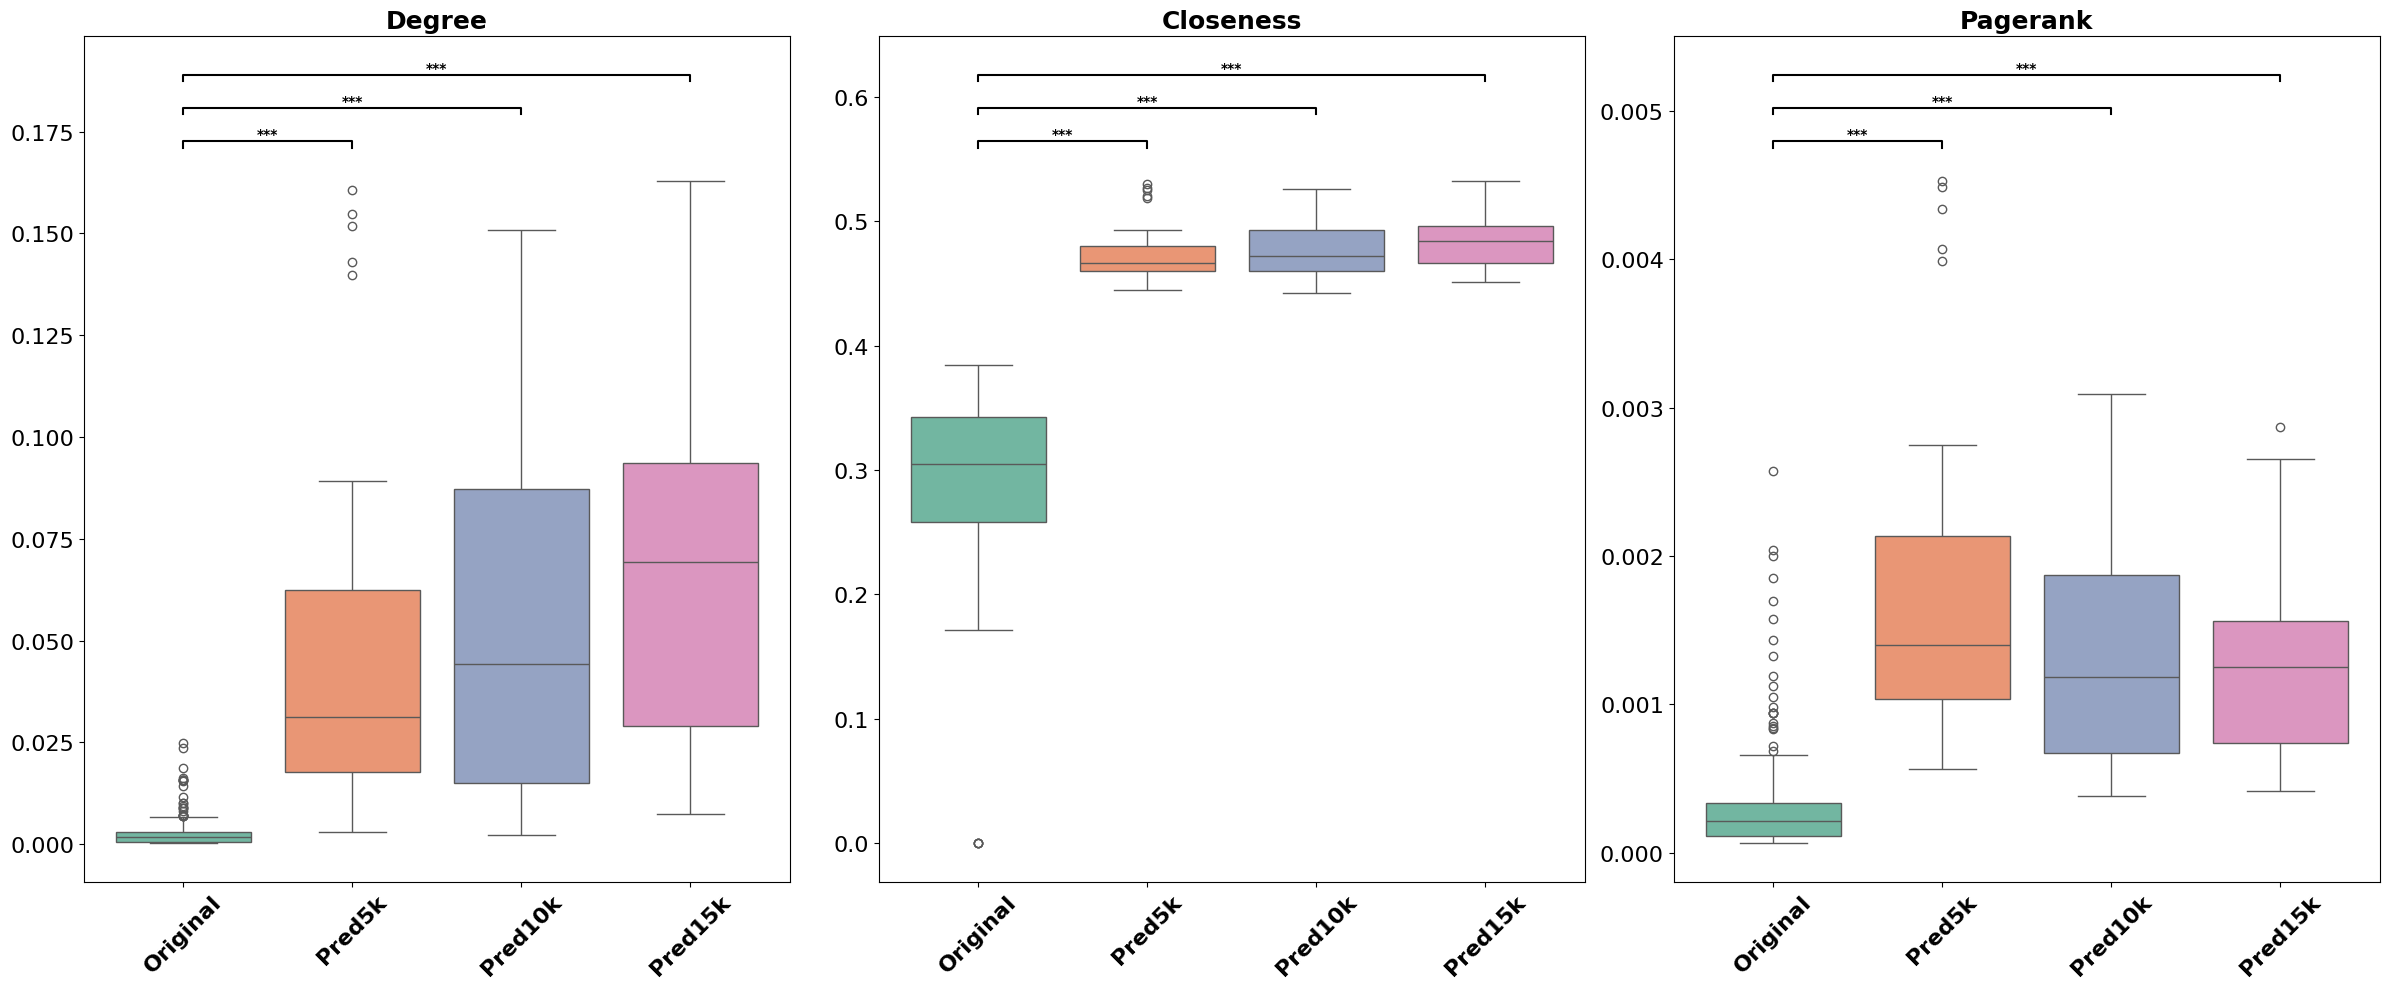

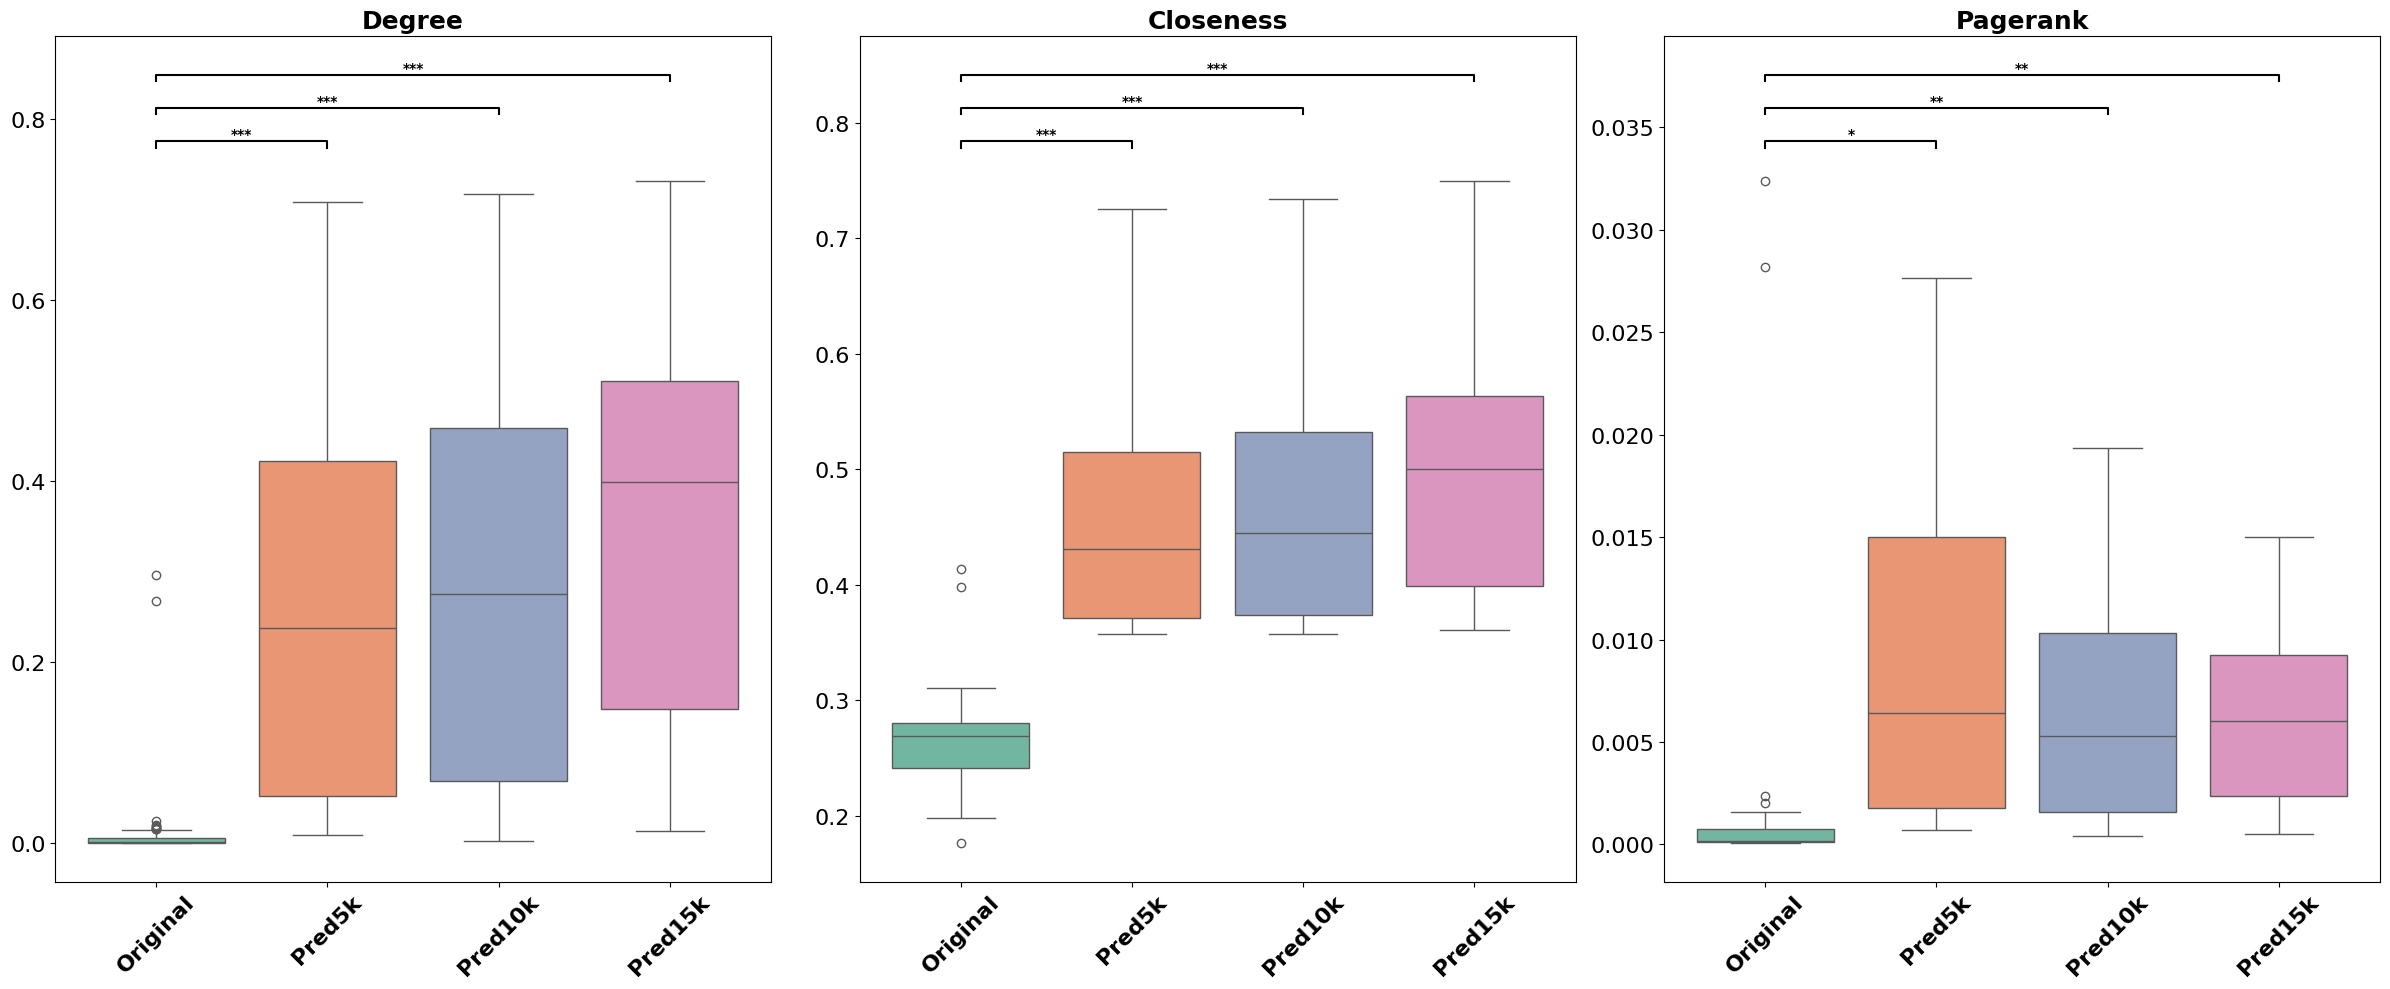

In [13]:
def paired_stat_summary(val_df, entity_label):
    """
    val_df: DataFrame with columns ['node','Network','degree','betweenness','closeness','pagerank']
            and only the validation nodes, with one row per (node,Network).
    entity_label: 'Protein' or 'Metabolite'
    """
    metrics = ['degree','betweenness','closeness','pagerank']
    preds   = ['Pred_top_5000','Pred_top_10000','Pred_top_15000']
    summary = []
    
    for metric in metrics:
        wide = val_df.pivot(index='node', columns='Network', values=metric)
        orig = wide['Original'].dropna()
        for pred in preds:
            pred_vals = wide[pred].reindex(orig.index).dropna()
            orig_vals = orig.reindex(pred_vals.index)
            if len(orig_vals) == 0:
                p = float('nan')
                median_diff = float('nan')
            else:
                stat, p = wilcoxon(pred_vals, orig_vals, alternative='greater')
                median_diff = float((pred_vals - orig_vals).median())
            summary.append({
                'Entity': entity_label,
                'Metric': metric,
                'Network': pred,
                'Median_Difference': median_diff,
                'p_value': p
            })
    return pd.DataFrame(summary)

prot_stats = paired_stat_summary(val_prot_df,   'Protein')
meta_stats = paired_stat_summary(val_meta_df,    'Metabolite')
stats_df   = pd.concat([prot_stats, meta_stats], ignore_index=True)

def sig_label(p):
    if p < 0.001: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    return 'ns'

stats_df['Signif'] = stats_df['p_value'].apply(sig_label)

def plot_with_stats(val_df, entity_label):
    plt.figure(figsize=(24,10))
    metrics = ['degree','closeness','pagerank']
    preds   = ['Original','Pred_top_5000','Pred_top_10000','Pred_top_15000']
    for i, metric in enumerate(metrics,1):
        ax = plt.subplot(1,3,i)
        sns.boxplot(x='Network', y=metric, data=val_df,
                    order=preds, palette='Set2', ax=ax)
        ax.set_title(f"{metric[0].upper()+metric[1:]}", fontsize=18, fontweight="bold")
        y_max = val_df[metric].max()
        y_min = val_df[metric].min()
        y_range = y_max - y_min
        sub = stats_df[(stats_df.Entity==entity_label)&(stats_df.Metric==metric)]
        for j, pred in enumerate(sub.Network, start=1):
            row = sub[sub.Network==pred].iloc[0]
            sig = row.Signif
            y = y_max + 0.05*y_range*(j)
            ax.plot([0,0,j,j],[y,y+0.01*y_range,y+0.01*y_range,y], color='black')
            ax.text((0+j)/2, y+0.01*y_range, sig, ha='center', va='bottom', fontweight="bold")
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=45, labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.set_xticklabels(['Original', 'Pred5k', 'Pred10k', 'Pred15k'], fontweight="bold")


    #plt.suptitle(f"{entity_label} Centrality Improvements vs. Original", fontsize=14)
    plt.savefig(f"{out_dir}{entity_label} validation_centrality_comparison_professional.png", dpi=500)
    plt.tight_layout()
    plt.show()

out_dir = '../results/topology/'
plot_with_stats(val_prot_df, 'Protein')
plot_with_stats(val_meta_df, 'Metabolite')
#stats_df.to_csv('../results/topology/hub_compare_sig.csv')
#val_prot_df.to_csv('../results/topology/hub_compare_prot.csv')
#val_meta_df.to_csv('../results/topology/hub_compare_meta.csv')

=== Overall Normalized Delta Rank Test ===
hub-hub: median Δnorm = -0.0698, p = 0.743
bridge: median Δnorm = 0.0483, p = 8.28e-07

=== Per-Meta_Type Delta Norm Analysis ===

-- hub-hub --
Carbohydrates: n=32, median Δnorm=0.4271, p=4.66e-10
Lipids: n=34, median Δnorm=0.1431, p=0.0157
Nucleic acids: n=290, median Δnorm=-0.2009, p=1
Organic acids: n=114, median Δnorm=0.1542, p=6.45e-08
Organoheterocyclic compounds: n=39, median Δnorm=0.1844, p=0.217

-- bridge --
Carbohydrates: n=32, median Δnorm=0.0670, p=0.00268
Lipids: n=34, median Δnorm=-0.1439, p=0.999
Nucleic acids: n=290, median Δnorm=0.0997, p=1.22e-23
Organic acids: n=114, median Δnorm=-0.0978, p=0.998
Organoheterocyclic compounds: n=39, median Δnorm=-0.0825, p=0.895


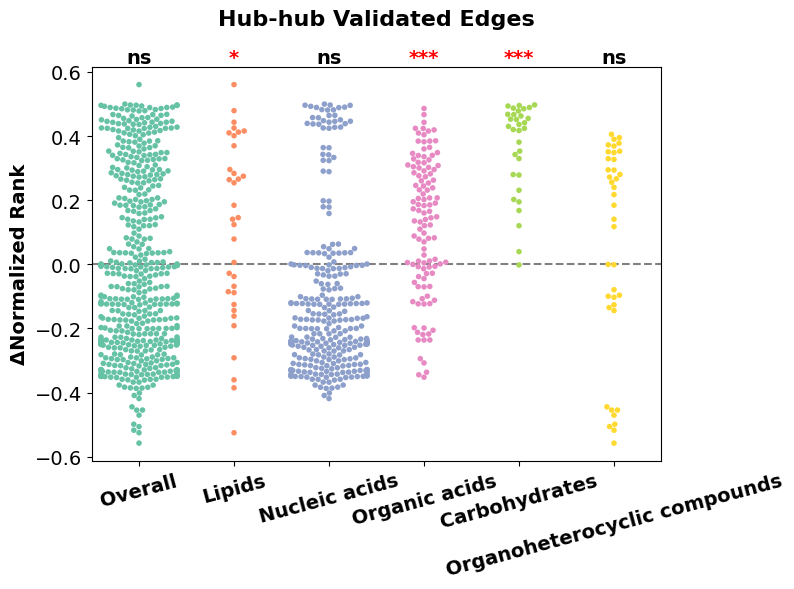

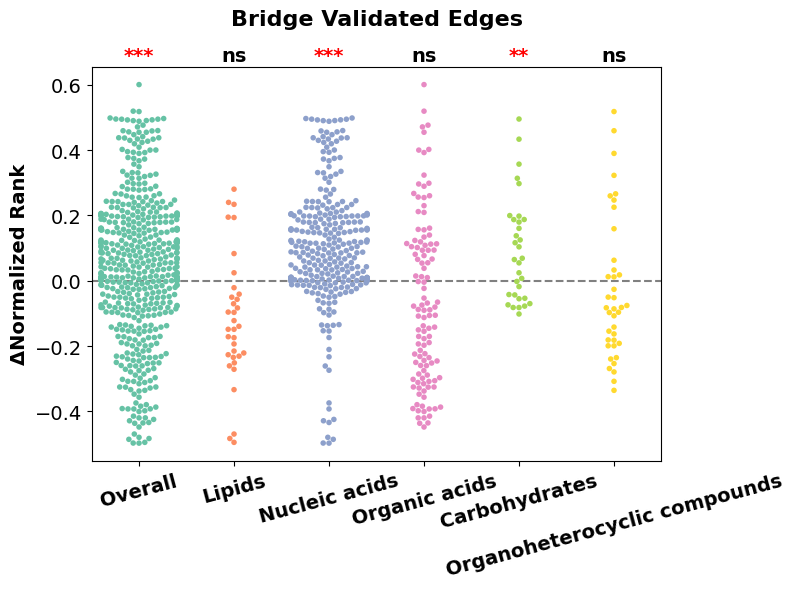

In [41]:
#2 edge importance
validated_pairs = set(blood_mapping_df[['hmdb', 'string']].dropna().drop_duplicates().itertuples(index=False, name=None))

def preprocess_and_normalize(df, rank_cols):
    df = df.copy()
    for col in rank_cols:
        max_rank = df[col].max(skipna=True)
        df[f'{col}_filled'] = df[col].fillna(int(2*(max_rank + 1)/4))
        max_filled = df[f'{col}_filled'].max()
        df[f'{col}_norm'] = df[f'{col}_filled'] / max_filled
    return df

rank_cols = ['Original', 'Pred_top_5000', 'Pred_top_10000', 'Pred_top_15000']
hhedge = preprocess_and_normalize(hhedge_df, rank_cols)
bgedge = preprocess_and_normalize(bgedge_df, rank_cols)

for df in [hhedge, bgedge]:
    df['is_validated'] = df.apply(lambda r: (r['Metabolite'], r['Protein']) in validated_pairs, axis=1)
    df['Meta_Type'] = df['Metabolite'].map(meta_type_dict).fillna('Unknown')
    df['delta_norm'] = df['Original_norm'] - df['Pred_top_15000_norm']

datasets = [('hub-hub', hhedge), ('bridge', bgedge)]

print("=== Overall Normalized Delta Rank Test ===")
for label, df in datasets:
    val = df[df['is_validated']]
    if val.empty:
        print(f"{label}: no validated edges.")
        continue
    stat, p = wilcoxon(val['delta_norm'], alternative='greater')
    median = val['delta_norm'].median()
    print(f"{label}: median Δnorm = {median:.4f}, p = {p:.3g}")


print("\n=== Per-Meta_Type Delta Norm Analysis ===")
for label, df in datasets:
    print(f"\n-- {label} --")
    val = df[df['is_validated']]
    for cat, group in val.groupby('Meta_Type'):
        if len(group) < 5:
            continue
        stat_cat, p_cat = wilcoxon(group['delta_norm'], alternative='greater')
        median_cat = group['delta_norm'].median()
        print(f"{cat}: n={len(group)}, median Δnorm={median_cat:.4f}, p={p_cat:.3g}")

        
for label, df in datasets:
    val = df[df['is_validated']]
    delta_overall = val['delta_norm'].values
    if len(delta_overall) > 0:
        stat_all, p_all = wilcoxon(delta_overall, alternative='greater')
        sig_all = '***' if p_all<0.001 else '**' if p_all<0.01 else '*' if p_all<0.05 else 'ns'
    else:
        p_all, sig_all = np.nan, ''
    
    cat_stats = {}
    for cat, grp in val.groupby('Meta_Type'):
        if len(grp) >= 5:
            stat_cat, p_cat = wilcoxon(grp['delta_norm'], alternative='greater')
            sig_cat = '***' if p_cat<0.001 else '**' if p_cat<0.01 else '*' if p_cat<0.05 else 'ns'
            cat_stats[cat] = {'n':len(grp), 'p':p_cat, 'sig':sig_cat, 'median':grp['delta_norm'].median()}
    
    plot_df = val[['delta_norm','Meta_Type']].copy()
    plot_df.loc[:, 'Meta_Type'] = plot_df['Meta_Type'].where(plot_df['Meta_Type'].map(lambda x: x in cat_stats), 'Other')
    overall_df = val[['delta_norm']].copy()
    overall_df['Meta_Type'] = 'Overall'
    plot_df = pd.concat([overall_df, plot_df], ignore_index=True)
    
    #allowed = ['Overall'] + sorted([c for c, s in cat_stats.items()],key=len)
    allowed = ['Overall', 'Lipids',  'Nucleic acids', 'Organic acids', 'Carbohydrates', 'Organoheterocyclic compounds']
    plot_df = plot_df[plot_df['Meta_Type'].isin(allowed)]
    
    plt.figure(figsize=(8,6))
    ax = sns.swarmplot(x='Meta_Type', y='delta_norm', data=plot_df,
                   order=allowed, palette='Set2', size=4)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"{label[0].upper()+label[1:]} Validated Edges", pad=30, fontsize=16, fontweight="bold" )
    plt.ylabel('ΔNormalized Rank', fontsize=14, fontweight="bold")
    plt.xlabel('')
    plt.xticks(rotation=15, fontsize=14,fontweight="bold")
    plt.yticks(fontsize=14)
    
    def sig_color(sig):
        return 'red' if sig in ['*', '**', '***'] else 'black'

    ypos = plot_df['delta_norm'].max()*1.1
    ax.text(0, ypos, sig_all, ha='center', va='bottom', fontsize=14, color=sig_color(sig_all), fontweight="bold")
    for i, cat in enumerate(allowed[1:], 1):
        sig = cat_stats[cat]['sig']
        ax.text(i, ypos, sig, ha='center', va='bottom', fontsize=14, color=sig_color(sig), fontweight="bold")
    
    plt.tight_layout()
    plt.savefig(f"{out_dir}{label}_delta_norm_with_stats.png", dpi=500)
    plt.show()

In [36]:
#3 pathway connectivity
metrics = ['reachability','lcc_size','global_efficiency']
keep_cats = [
    'Carbohydrates', 'Nucleic acids', 'Organic acids',
    'Lipids',  'Organoheterocyclic compounds'
]

validated_pairs = set(
    blood_mapping_df.dropna()[['hmdb','string']]
    .drop_duplicates()
    .itertuples(index=False, name=None)
)

pivot = pathway_df.pivot(index='Pathway', columns='Network', values=['num_nodes','num_edges'])
keep = pivot['num_nodes'].min(axis=1) >= 3
keep &= (pivot['num_edges']['Pred_top_15000'] > 0)
keep_pw = keep[keep].index.tolist()
cat_counts = {pw:{cat:0 for cat in set(meta_type_dict.values())} for pw in keep_pw}
pf = pathway_df[pathway_df['Pathway'].isin(keep_pw)].copy()

orig = pf[pf.Network=='Original'].set_index('Pathway')
pred = pf[pf.Network=='Pred_top_15000'].set_index('Pathway')
delta = pd.DataFrame({
    'Pathway': keep_pw,
    **{f'delta_{m}': pred[m] - orig[m] for m in metrics}
})

val_count = {pw:0 for pw in keep_pw}
for m,p in validated_pairs:
    m_k = set(hmdb_kegg_dict.get(m,[]))
    p_k = set(string_kegg_dict.get(p,[]))
    for pw in keep_pw:
        if m_k & set(kegg_m_dict.get(pw,[])) and p_k & set(kegg_p_dict.get(pw,[])):
            val_count[pw] += 1
delta['has_validated'] = delta['Pathway'].map(lambda pw: val_count[pw]>0)
delta['count_validated'] = delta['Pathway'].map(val_count)


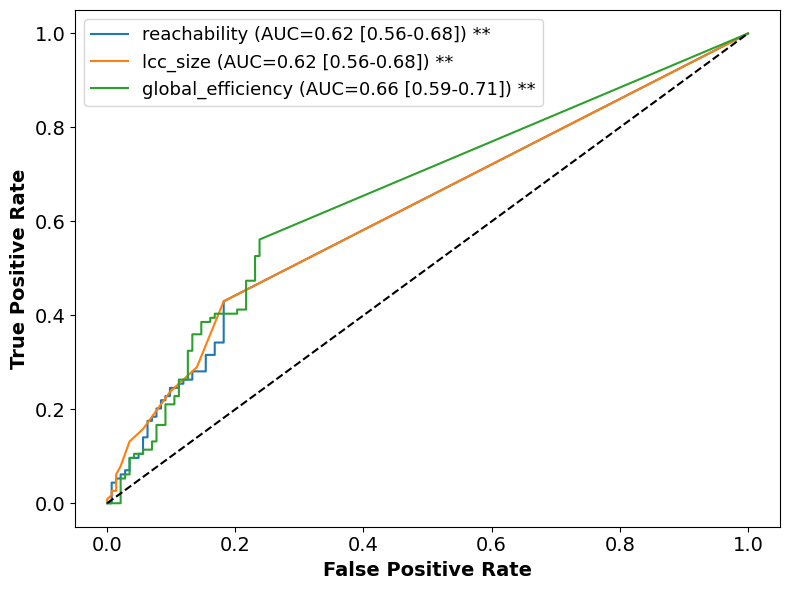

In [46]:
def bootstrap_auc_ci(y_true, y_score, n_bootstraps=1000, ci=0.95):
    rng = np.random.RandomState(42)
    aucs = []
    for _ in range(n_bootstraps):
        idx = rng.choice(range(len(y_true)), size=len(y_true), replace=True)
        if len(np.unique(y_true[idx])) < 2:
            continue  
        aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
    lower = np.percentile(aucs, (1 - ci) / 2 * 100)
    upper = np.percentile(aucs, (1 + ci) / 2 * 100)
    return np.mean(aucs), (lower, upper)

def significance_star(lower_ci, alpha=0.05):
    if lower_ci > 0.5 + 0.1:
        return '***'
    elif lower_ci > 0.5 + 0.05:
        return '**'
    elif lower_ci > 0.5:
        return '*'
    else:
        return 'ns'

auc_results = []
plt.figure(figsize=(8,6))
y_true = delta['has_validated'].astype(int)

for m in metrics:
    y_score = delta[f'delta_{m}'].values
    if np.unique(y_score).size > 1:
        auc, (ci_low, ci_high) = bootstrap_auc_ci(y_true.values, y_score)
        star = significance_star(ci_low)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        label = f"{m} (AUC={auc:.2f} [{ci_low:.2f}-{ci_high:.2f}]) {star}"
        plt.plot(fpr, tpr, label=label)
        auc_results.append({'metric':m, 'auc':auc, 'ci_low':ci_low, 'ci_high':ci_high, 'sig':star})

plt.plot([0,1],[0,1],'k--')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14, fontweight="bold")
plt.ylabel('True Positive Rate', fontsize=14, fontweight="bold")
#plt.title('ROC Curves: Predicting Pathways with Any Validated Pair\n(*: Significantly better than random)', pad=10)
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig(f"{out_dir}pathway_validated_roc_CI_sig.png", dpi=300)

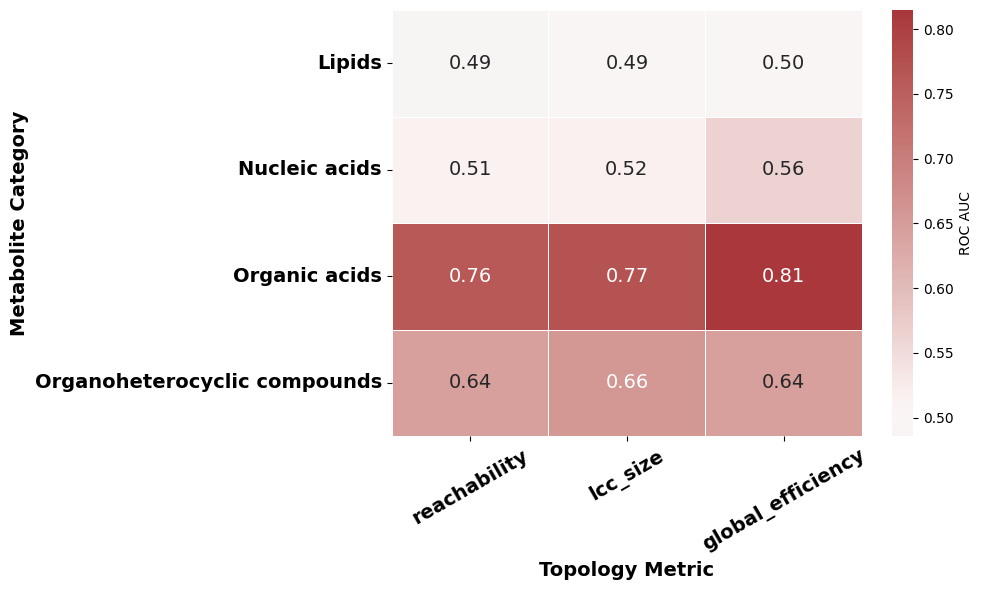

In [51]:
path_cats = {pw:{} for pw in keep_pw}
for pw in keep_pw:
    path_cats[pw] = {}
    for cat in set(meta_type_dict.values()):
        path_cats[pw][cat] = 0
for m,p in validated_pairs:
    m_k = set(hmdb_kegg_dict.get(m,[]))
    p_k = set(string_kegg_dict.get(p,[]))
    cat = meta_type_dict.get(m,'Unknown')
    for pw in keep_pw:
        if m_k & set(kegg_m_dict.get(pw,[])) and p_k & set(kegg_p_dict.get(pw,[])):
            path_cats[pw][cat] += 1

cat_auc = []
for i,cat in enumerate(sorted(path_cats[keep_pw[0]].keys())):
    y = np.array([path_cats[pw][cat]>0 for pw in delta['Pathway']])
    for m in metrics:
        scores = delta[f'delta_{m}'].values
        if y.sum()>=5 and np.unique(scores).size>1:
            auc = roc_auc_score(y, scores)
            cat_auc.append({'category':cat,'metric':m,'auc':auc})
cat_auc_df = pd.DataFrame(cat_auc).pivot(index='category',columns='metric',values='auc')
cat_auc_df_filtered = cat_auc_df.loc[
    cat_auc_df.index.intersection(keep_cats), 
    metrics
]

plt.figure(figsize=(10,6))
sns.heatmap(
    cat_auc_df_filtered,
    cmap='vlag',
    center=0.5,
    annot=True,
    fmt='.2f',
    annot_kws={"size": 14},
    cbar_kws={'label':'ROC AUC'},
    linewidths=0.5,
    linecolor='white'
)
#plt.title('Category-wise ROC AUC for ΔMetrics', fontsize=14,pad=10)
plt.xlabel('Topology Metric', fontsize=14, fontweight="bold")
plt.ylabel('Metabolite Category', fontsize=14, fontweight="bold")
plt.yticks(rotation=0, fontsize=14, fontweight="bold")
plt.xticks(rotation=30, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(f"{out_dir}category_roc_auc_heatmap.png", dpi=300)